<a href="https://colab.research.google.com/github/vaa2114/capstone-project-2019/blob/master/hws/Causal_hw3_vaa2114.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Causal Inference - HW #3
#### Name - Vineet Aguiar
#### Uni - Vaa2114

#### 1a) Causal Graph for the system 

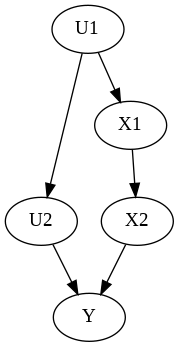

In [1]:
import pydot
from IPython.display import Image, display, Markdown

G = pydot.Dot()
G.add_node(pydot.Node(name='U1'))
G.add_node(pydot.Node(name='U2'))
G.add_node(pydot.Node(name='X1'))
G.add_node(pydot.Node(name='X2'))
G.add_node(pydot.Node(name='Y'))

G.add_edge(pydot.Edge('U1', 'X1'))
G.add_edge(pydot.Edge('U1', 'U2'))
G.add_edge(pydot.Edge('X1', 'X2'))
G.add_edge(pydot.Edge('X2', 'Y'))
G.add_edge(pydot.Edge('U2', 'Y'))

plt = Image(G.create_png())
display(plt)

#### 1b) Set of back-door variables for the effect of $X_1$ on Y

- $Z$ = {$U_1$}

#### 1c) Data-generating process
- $U_1$ ~ ${N(0,1)}$
- $U_2$ ~ ${N(\beta_{U_1, U_2} U_1,1)}$
- $X_1$ ~ ${Binomial(1, p=logit^{-1}(\beta_{U_1, X_1} U_2))}$
- $X_2$ ~ ${N(\beta_{X_1, X_2} X_1,1)}$
- $Y$ ~ ${N(\beta_{X_2, Y} X_2 + \beta_{U_2, Y} U_2,1)}$



In [0]:
import numpy as np
import pandas as pd

N = 1000

u1 = np.random.normal(0, 1, size=N) # mean around 0

beta_u1u2 = 0.1
u2 = np.random.normal(beta_u1u2*u1, 1) # mean around 0 

beta_u1x1 = 0.1
# beta_u1x1 = np.random.normal(1, size=N)
p_x1_given_u1 = 1. /(1 + np.exp(-beta_u1x1 * u1))
x1 = np.random.binomial(1, p=p_x1_given_u1)

beta_x1x2 = np.random.normal(1, size=N)
# beta_x1x2 = 0.02
x2 = np.random.normal(beta_x1x2 * x1, 1) #

# beta_x2y = np.random.normal(1, size=N)
# beta_u2y = np.random.normal(1, size=N)

beta_x2y = 1
beta_u2y = 0.02

y = np.random.normal((beta_x2y * x2 + beta_u2y * u2), 1)

df = pd.DataFrame({'u1': u1, 'u2': u2, 'x1' : x1, 'x2' : x2, 'y' : y})

Plotting U1 and U2


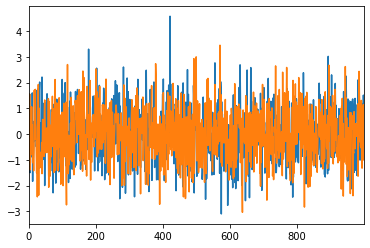

In [50]:
df['u1'].plot()
df['u2'].plot()

print("Plotting U1 and U2")

Plotting X1(Binomial) and Y


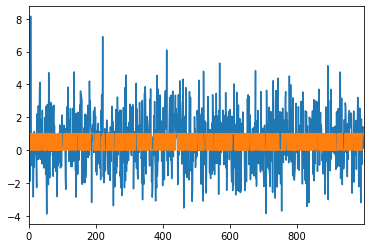

In [51]:
df['y'].plot()
df['x1'].plot()
# df['x2'].plot()

print("Plotting X1(Binomial) and Y")

#### 1d)True and naive averate treatment effect
- ${\delta}$ = 1


In [53]:
delta_naive = df.groupby('x1').mean()['y'][1] - df.groupby('x1').mean()['y'][0]
print("𝛿𝑛𝑎𝑖𝑣𝑒: ", delta_naive)

𝛿𝑛𝑎𝑖𝑣𝑒:  1.1255756790991407


#### 1e) Using OLS with the backdoor set ${U1}$ to make an unbiased estimate $\delta_{OLS}$


In [54]:
from statsmodels.api import OLS

df['intercept'] = 1
model = OLS(endog=df['y'], 
            exog=df[['x1', 'u1', 'intercept']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     63.16
Date:                Sun, 08 Mar 2020   Prob (F-statistic):           1.49e-26
Time:                        23:07:45   Log-Likelihood:                -1877.3
No. Observations:                1000   AIC:                             3761.
Df Residuals:                     997   BIC:                             3775.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1234      0.101     11.170      0.000       0.926       1.321
u1             0.0121      0.049      0.247      0.805      -0.084       0.108
intercept     -0.0268      0.071     -0.377      0.706      -0.166       0.113
==============================================================================
Omnibus:                        6.497   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.395
Skew:                           0.039   Prob(JB):                       0.0150
Kurtosis:                       3.442   Cond. No.                         2.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
delta_ols = round(result.params['x1'], 4)
std_err_ols = round(result.bse['x1'], 4)

int1 = round( delta_ols - (1.96 * std_err_ols), 4)
int2 = round( delta_ols + (1.96 * std_err_ols), 4)

print("𝛿_𝑂𝐿𝑆:", delta_ols)
print("Standard error for 𝛿_𝑂𝐿𝑆:", std_err_ols)
print(f"95% Confidence Interval: ({int1}, {int2})")

𝛿_𝑂𝐿𝑆: 1.1234
Standard error for 𝛿_𝑂𝐿𝑆: 0.1006
95% Confidence Interval: (0.9262, 1.3206)


#### 1f) Inverse Propensity Weighted OLS with not covariates (Unbiased est of the ATE)

- Creating the propensity score model

In [56]:
from statsmodels.discrete.discrete_model import Logit

df['intercept'] = 1
model = Logit(endog=df['x1'], 
              exog=df[['u1', 'intercept']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.689131
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     x1   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                0.005791
Time:                        23:08:15   Log-Likelihood:                -689.13
converged:                       True   LL-Null:                       -693.15
Covariance Type:            nonrobust   LLR p-value:                  0.004608
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
u1             0.1751      0.062      2.816      0.005       0.053       0.297
intercept      0.0006      0.064      0.010      0.992      -0.124       0.125
==============================================================================
"""

- Calculating the propensity score

In [0]:
df['propensity_score'] = df['x1'] * result.predict() + \
                         (1 - df['x1']) * (1 - result.predict())

- Use the weights in the OLS regression model

In [58]:
df['intercept'] = 1
df['weight'] = 1. / df['propensity_score']
model = OLS(endog=df['y'], 
            exog=df[['x1', 'intercept']],
            weights=df['weight']
           )
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1266.
Date:                Sun, 08 Mar 2020   Prob (F-statistic):          1.01e-179
Time:                        23:08:21   Log-Likelihood:                -1877.3
No. Observations:                1000   AIC:                             3759.
Df Residuals:                     998   BIC:                             3768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1256      0.100     11.242      0.000       0.929       1.322
intercept     -0.0277      0.071     -0.390      0.696      -0.167       0.111
==============================================================================
Omnibus:                        6.494   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.397
Skew:                           0.038   Prob(JB):                       0.0150
Kurtosis:                       3.442   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
delta_prop = round(result.params['x1'], 4)
std_err_prop = round(result.bse['x1'], 4)

int1 = round( delta_prop - (1.96 * std_err_prop), 4)
int2 = round( delta_prop + (1.96 * std_err_prop), 4)

print("𝛿_IPW:", delta_prop)
print("Standard error for 𝛿_IPW:", std_err_prop)
print(f"95% Confidence Interval: ({int1}, {int2})")

𝛿_IPW: 1.1256
Standard error for 𝛿_IPW: 0.1001
95% Confidence Interval: (0.9294, 1.3218)


#### 1g) Higher Capacity ML model (RandomForestRegressor) to computer $\delta_{ML}$

In [0]:
from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_estimators=N)
# model = model.fit(df[['x1']],
#                   df['y'],
#                   sample_weight=df['weight'])

# df_1 = df.copy()
# df_0 = df.copy()

# df_1['x1'] = 1
# y_1 = model.predict(df_1[['x1']])

# df_0['x1'] = 0
# y_0 = model.predict(df_0[['x1']])

samples = 30 
deltas = []

for _ in range(samples):
    df_sample = df.sample(n=len(df), replace=True)

    model = RandomForestRegressor(n_estimators=N)
    model = model.fit(df_sample[['x1']],
                      df_sample['y'],
                      sample_weight=df_sample['weight'])

    df_1 = df_sample.copy()
    df_0 = df_sample.copy()

    df_1['x1'] = 1
    y_1 = model.predict(df_1[['x1']])

    df_0['x1'] = 0
    y_0 = model.predict(df_0[['x1']])

    deltas.append((y_1 - y_0).mean())

deltas = pd.Series(deltas)

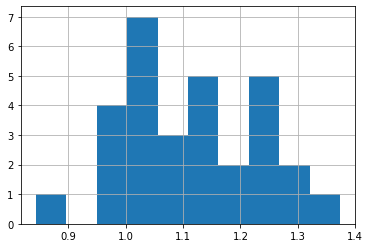

In [65]:
deltas.hist()

In [66]:
delta_ML = round((y_1 - y_0).mean(),4)
std_err_ML = round( ((abs(y_1 - df_1['x1']).mean() + abs(y_0 - df_0['x1']).mean()) / 2 ), 4)

int1 = round( delta_ML - (1.96 * std_err_ML), 4)
int2 = round( delta_ML + (1.96 * std_err_ML), 4)

print("𝛿_𝑀𝐿: ", delta_ML)
print("Standard error for 𝛿_IPW:", std_err_ML)
print(f"95% Confidence Interval: ({int1}, {int2})")


𝛿_𝑀𝐿:  0.8431
Standard error for 𝛿_IPW: 0.0784
95% Confidence Interval: (0.6894, 0.9968)


#### 1h) Doubly robust Estimate $\delta_{DR,ML}$ by adding the variable $U2$ as a predictor

In [0]:
samples = 30 
deltas = []

for _ in range(samples):
    df_sample = df.sample(n=len(df), replace=True)

    model = RandomForestRegressor(n_estimators=N)
    model = model.fit(df_sample[['x1', 'u2']],
                      df_sample['y'],
                      sample_weight=df_sample['weight'])

    df_1 = df_sample.copy()
    df_0 = df_sample.copy()

    df_1['x1'] = 1
    y_1 = model.predict(df_1[['x1', 'u2']])

    df_0['x1'] = 0
    y_0 = model.predict(df_0[['x1', 'u2']])

    deltas.append((y_1 - y_0).mean())

deltas = pd.Series(deltas)

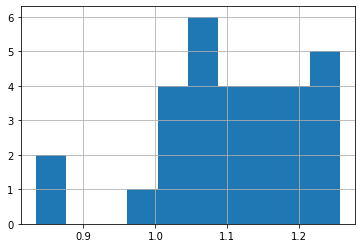

In [68]:
deltas.hist()

In [69]:
print("Average 𝛿_DR,ML: ", round(deltas.mean(),4))

Average 𝛿_DR,ML:  1.1063
